# Data Types

## Introduction to quantum data: the qubit
Qualtran lets you write quantum programs that operate on quantum data. The smallest unit of quantum data is the qubit ("quantum bit"). A quantum bit can be in the familiar `0` or `1` states (called computational basis states) or any combination of them, like $|+\rangle = (|0\rangle + |1\rangle)/\sqrt{2}$. Allocation-like bloqs can allocate a qubit in a particular state. Below, we create a simple program that allocates one quantum vairalbe in the `0` state and one in the `+` state.

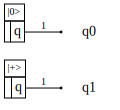

In [1]:
from qualtran import BloqBuilder
from qualtran.bloqs.basic_gates import ZeroState, PlusState

bb = BloqBuilder()
zero_q = bb.add(ZeroState())
plus_q = bb.add(PlusState())
cbloq = bb.finalize(q0=zero_q, q1=plus_q)

from qualtran.drawing import show_bloq
show_bloq(cbloq)

## Quantum variables

When we use [`BloqBuilder`](/reference/qualtran/BloqBuilder.md) to `add` these allocation operations to our program, we are given a handle to the resulting quantum data. These handles are *quantum variables*, which can be provided as inputs to subsequent operations. Quantum variables follow *linear logic*: that is, each quantum variable must be used exactly once. You cannot use the same variable twice (this would violate the *no-cloning theorem*), and you cannot leave a variable unused (this would violate the corresponding *no-deleting theorem*). In the above program, we use the `finalize` method to account for our unused quantum variables&mdash;it is presumed that the programmer will handle these piece of data with subsequent bloqs.

## Bloq signatures and `QBit()`

We write quantum programs by composing subroutines encoded as Qualtran *bloqs*. A bloq class inherits from the `qualtran.Bloq` interface, which only has one required property: `signature`. A bloq's signature declares the names and types of quantum data the bloq takes as input and output. You might think of a bloq with nothing other than its signature analogous to declaring (but not defining) a function in a C/C++ header file. 

The `Bloq.signature` property method must return a `qualtran.Signature` object, which is itself a list of [`Register`](/reference/qualtran/Register.md) objects. Each register is the name and data type of an input/output variable. In quantum computing (as a consequence of the no-deleting theorem), we often have a pattern we term *thru registers* where quantum data is used as input and returned with the same name and data type, so registers default to simultaneous input and output arguments.

Below, we construct a signature consisting of two input-output arguments named 'arg1' and 'arg2'; and we declare that each must be a qubit using the data type specification `qualtran.QBit()`. 

In [2]:
from qualtran import Signature, Register, QBit

signature = Signature([
    Register('arg1', QBit()),
    Register('arg2', QBit()),
])
print(signature.n_qubits())

2


## Quantum data types

Completely analogously to classical computation, collections of individual qubits can be used to encode a variety of data types. For example, `qualtran.QUInt(32)` represents a 32-bit unsigned, quantum integer. These data type objects are used in the definition of signatures to provide type checking for your quantum programs. 

In Qualtran, quantum variables of arbitrary type are first-class objects. You can represent a program operating on e.g. 2048-bit registers without having a unique index or an individual Python object for each underlying qubit (like in many NISQ frameworks like Cirq). 

We support statically-sized data; and do not support sum or union types. Built-in data types like `QInt`, `QFxp` (fixed-point reals), `QIntOnesComp` (signed integers using ones' complement), and others are available in the top-level `qualtran` namespace. Custom data types can be implemented by inheriting from `QDType`.

Below, we construct a signature consisting of two input-output arguments named 'x' and 'y'; and we declare that each is a 32-bit quantum unsigned integer.

In [3]:
from qualtran import QUInt

signature = Signature([
    Register('x', QUInt(32)),
    Register('y', QUInt(32)),
])
print(signature.n_qubits())

64


### Quantum data types as bloq parameters

By using compile-time classical attributes of bloqs, we can support *generic programming* where a single bloq class can be used with a variety of quantum data types. Many of the arithmetic operations take the data type as a compile-time classical attribute.

Below, we show that the `Negate` operation can handle a `QUInt` of arbitrary size; and indeed you can read the documentation to figure out that it also supports signed and other types of integers. Note: we can represent programs on large bitsize variables without any performance overhead.

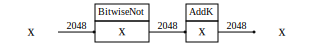

In [4]:
from qualtran.bloqs.arithmetic import Negate

negate = Negate(dtype=QUInt(2048))
show_bloq(negate.decompose_bloq())

## Splitting

It is great if you can express your algorithm as manipulations of quantum ints, reals, or other *high-level* data types. But, we anticipate that the gateset of a quantum computer will consist of 1-, 2- and 3-qubit operations. At some point, we need to define our operations in terms of their action on individual bits. We can use `Split` and other *bookkeeping* operations to carefully cast the data type of a quantum variable so we can write decompositions down to the architecture-supported gateset.

As an example, we'll consider the `BitwiseNot` used in the previous snippet. We'll take a quantum unsigned integer and just do a *not* (in quantum computing: `XGate`) on each bit.

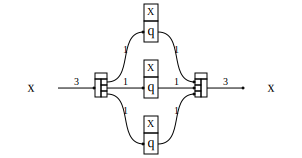

In [5]:
from qualtran.bloqs.basic_gates import XGate

dtype = QUInt(3)  # 3-bit integer for demonstration purposes

# We'll use BloqBuilder directly. In the standard library this would
# be the `build_composite_bloq` method on the `BitwiseNot` bloq class
bb = BloqBuilder()
x = bb.add_register_from_dtype('x', dtype)

# First, we split up the bits using the `.split` helper method on BloqBuilder.
# It returns a numpy array of quantum variables.
x_bits = bb.split(x)

# Then, we apply the XGate to each bit. Remember that each quantum variable
# must be used exactly once, so the input bits are consumed by the XGate and
# we get a new variable back that we store in our `x_bits` array.
for i in range(len(x_bits)):
    x_bits[i] = bb.add(XGate(), q=x_bits[i])

# For users calling this bloq, we want the fact that we split up all the bits
# to be an "implementation detail"; so we re-join our output bits back into
# a 3-bit unsigned integer
x = bb.join(x_bits, dtype=dtype)

# Finish up and draw a diagram
cbloq = bb.finalize(x=x)
show_bloq(cbloq)

## Endianness

The Qualtran data types use a big-endian bit convention. The most significant bit is at index 0.

In [6]:
QUInt(8).to_bits(x=0x30)

[0, 0, 1, 1, 0, 0, 0, 0]

## Casting and QAny

In general, we can cast from one data type to another using the `Cast` bloq. The system will validate that the number of bits between the two data types match, but this operation must still be done with some care.

When type checking is irrelevant, you can use the `QAny(n)` type to represent an arbitrary collection of qubits that doesn't necessarily encode anything. 

Below, we allocate individual qubits and then join them into a new quantum variable. Since there's no type information, the resulting variable will have the `QAny(3)` type. We can declare that this should encode a `QUInt(3)` by using a `Cast`. (There's also a `dtype` argument to `bb.join`, which you would probably use in practice).

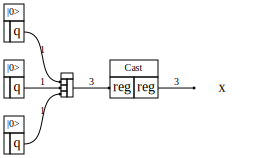

In [7]:
bb = BloqBuilder()

# Make three |0> qubits
qs = [bb.add(ZeroState()) for _ in range(3)]

# Join them into one quantum variable. Since
# we don't specify a type, `x` is `QAny(3)`. 
x = bb.join(qs)

# Maybe we're trying to allocate an unsigned integer.
from qualtran.bloqs.bookkeeping import Cast
from qualtran import QAny
x = bb.add(Cast(inp_dtype=QAny(3), out_dtype=QUInt(3)), reg=x)

cbloq = bb.finalize(x=x)
show_bloq(cbloq)

## Type checking

When wiring up bloqs, the data types must be compatible. 

 - When the two data types are the same, they are always compatible
 - All single-qubit data types are compatible

The consistency checking functions accept a severity parameter. If it is set to `STRICT`, then nothing outside of the above two rules are compatible. If it is set to `LOOSE` (the default), the following pairs are also compatible:

 - `QAny` is compatible with any other data type if its number of qubits match
 - Integer types are mutually compatible if the number of qubits match
 - An unsigned `QFxp` fixed-point with only an integer part is compatible with integer types.

In [8]:
from qualtran import QDTypeCheckingSeverity, check_dtypes_consistent

print('same  ', check_dtypes_consistent(QUInt(3), QUInt(3)))
print('1bit  ', check_dtypes_consistent(QBit(), QAny(1)))
print('qany  ',
    check_dtypes_consistent(QAny(3), QUInt(3)),
    check_dtypes_consistent(QAny(3), QUInt(3), QDTypeCheckingSeverity.STRICT)
)
from qualtran import QInt
print('qint  ', 
    check_dtypes_consistent(QUInt(3), QInt(3)),
    check_dtypes_consistent(QUInt(3), QInt(3), QDTypeCheckingSeverity.STRICT)
)
print('diff  ', check_dtypes_consistent(QAny(3), QAny(4)))

same   True
1bit   True
qany   True False
qint   True False
diff   False


## `QDType`, `CDType`, and `QCDType`

Quantum variables are essential when authoring quantum programs, but we live in a classical world. Measuring a qubit yields a classical bit, and a program can do classical branching (choosing which quantum operations to execute based on a classical bit). Each data type we've seen so far is a quantum data type and inherits from `QDType`. 

In [9]:
from qualtran import QDType

print("QBit()   is QDType:", isinstance(QBit(), QDType),   "; num_qubits =", QBit().num_qubits)
print("QUInt(4) is QDType:", isinstance(QUInt(4), QDType), "; num_qubits =", QUInt(4).num_qubits)

QBit()   is QDType: True ; num_qubits = 1
QUInt(4) is QDType: True ; num_qubits = 4


There is a more general base class: `QCDType` that includes both quantum and classical data types. Classical data types inherit from `CDType`

In [10]:
from qualtran import QCDType, QDType, CDType, CBit

dtypes = [QBit(), QUInt(4), CBit()]

print(f"{'dtype':10} {'QCDType?':9s} {'QDType?':9s} {'CDType?':9s}"
      f"{'bits':>6s} {'qubits':>6s} {'cbits':>6s}"
     )
print("-"*60)
for dtype in dtypes:
    print(f"{dtype!s:10} {isinstance(dtype, QCDType)!s:9} {isinstance(dtype, QDType)!s:9} {isinstance(dtype, CDType)!s:9}"
          f"{dtype.num_bits:6d} {dtype.num_qubits:6d} {dtype.num_cbits:6d}"
         )

dtype      QCDType?  QDType?   CDType?    bits qubits  cbits
------------------------------------------------------------
QBit()     True      True      False         1      1      0
QUInt(4)   True      True      False         4      4      0
CBit()     True      False     True          1      0      1
